Predicting Stock Prices Using Monte Carlo Methods in Python
Determine the most likely price of SPY next year using a Monte Carlo simulation!
By Zack Fizell

The stock market is one of the most studied areas in history. People have been trying to predict future prices for decades now. Most, if not all, people struggle with this task because the stock market is a stochastic process. Stochastic processes are inherently difficult or impossible to accurately predict due to their randomness. That is where Monte Carlo simulations come in. These simulations are great for determining outcomes of processes or events that have random variables. The stock market for example has unknown randomized events such as news, world events, investor sentiment, etc. All of these create a stochastic system that makes creating models to predict future prices practically impossible.

In this article, we will be attempting to predict the stock price of SPY a year from now using historical data and statistics. Note this is not investing advice. This is solely for educational purposes and to demonstrate how Monte Carlo methods can be applied to the stock market. This model can be applied to your favorite stock, ETF, or cryptocurrency, and if desired, it can be expanded to any stochastic process to determine the most likely outcome of a randomized event. Let’s get into the code.

Importing Packages
For this code, we will need the following packages:

. yfinance is used to pull historical finance data
. numpy is used for calculating statistics parameters of stock price changes
. random is used to create a randomized result (key to the Monte Carlo simulation)
. pyplot is used to visualize our results
. norm is used in conjunction with the random package to randomize a daily stock gain (explained   later in the article)


In [1]:
# Importing Packages
import yfinance as yf
import numpy as np
from random import random
import matplotlib.pyplot as plt
from scipy.stats import norm

Obtaining and Displaying Historical Data

The next step is generating historical financial data using yfinance. In this article, we will use the stock ticker SPY, or the SPDR S&P 500 ETF Trust. In order to pull the data, we need to define the start and end date of the desired interval of interest. I used 10 years prior to the day of writing this. We are going to focus on the daily closing prices of SPY, so we will pull that data from the data frame and plot it.

                  Open        High         Low       Close     Volume  \
Date                                                                    
2012-05-04  114.521558  115.166422  113.198751  113.264893  193927300   
2012-05-07  112.859772  113.727863  112.818445  113.347565  127765900   
2012-05-08  112.669642  113.074754  111.545260  112.892868  213377700   
2012-05-09  111.694055  112.942444  111.189736  112.223175  220752500   
2012-05-10  113.000328  113.140886  112.198391  112.454681  150600000   

            Dividends  Stock Splits  
Date                                 
2012-05-04        0.0             0  
2012-05-07        0.0             0  
2012-05-08        0.0             0  
2012-05-09        0.0             0  
2012-05-10        0.0             0  
                 Close
Date                  
2012-05-04  113.264893
2012-05-07  113.347565
2012-05-08  112.892868
2012-05-09  112.223175
2012-05-10  112.454681
...                ...
2022-04-27  417.269989
2022-04-28  427

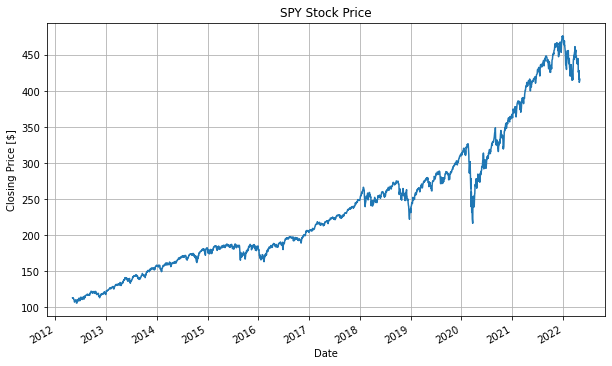

In [2]:
# Defining the Ticker
ticker = yf.Ticker('SPY')

# Obtaining Historical Market Data
start_date = '2012-05-04'
end_date = '2022-05-04'
hist = ticker.history(start=start_date, end=end_date)
print(hist.head())

# Pulling Closing Price Data
hist = hist[['Close']]
print(hist)

# Plotting Price Data
hist['Close'].plot(title="SPY Stock Price", ylabel=
                   "Closing Price [$]", figsize=[10, 6])
plt.grid()

# The code above generates the following output and plot. 
# Notice the head() function is used to plot the first five rows of the hist data frame.

Stock Statistics

Let’s analyze the closing prices of SPY for use later on. First, we will need to create a couple lists: days for plotting purposes and price_orig to use the closing price data from the hist data frame. We create one more list, change, which is the percent change day to day of SPY for the last 10 years. Using change and numpy, we can calculate the mean and standard deviation of the price changes during the time period of interest. We will use these in our Monte Carlo loops next.

In [4]:
# Create Day Count, Price, and Change Lists
days = [i for i in range(1, len(hist['Close'])+1)]
price_orig = hist['Close'].tolist()
change = hist['Close'].pct_change().tolist()
change = change[1:]  # Removing the first term since it is NaN

# Statistics for Use in Model
mean = np.mean(change)
std_dev = np.std(change)
print('\nMean percent change: ' + str(round(mean*100, 2)) + '%')
print('Standard Deviation of percent change: ' +   
      str(round(std_dev*100, 2)) + '%')


Mean percent change: 0.06%
Standard Deviation of percent change: 1.04%


Preparing for Simulation

Before we start the Monte Carlo portion, we need to set up a few things in order to analyze our results. First, we need to define the number of simulations we want to run, simulations, and the number of days we are predicting, days_to_sim. In this code, we will simulate for 1 year (or 252 trading days) and perform 200 simulations (chosen arbitrarily, the more the better).

Next, we will initialize a plot. Setting it up before the simulation, allows us to add lines after each year is predicted. Notice we also plot the original 10 years of data but cut it after 2000 days (to better visualize the prediction lines). Finally, we initialize two lists that will track the year out the closing price of a prediction, close_end, and if that closing price is above the closing price of 5/4/2022, above_close.

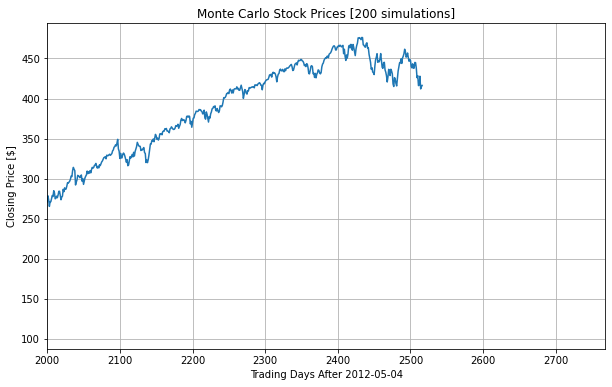

In [5]:
# Simulation Number and Prediction Period
simulations = 200 # Change for more results
days_to_sim = 1*252 # Trading days in 1 year

# Initializing Figure for Simulation
fig = plt.figure(figsize=[10, 6])
plt.plot(days, price_orig)
plt.title("Monte Carlo Stock Prices [" + str(simulations) + 
          " simulations]")
plt.xlabel("Trading Days After " + start_date)
plt.ylabel("Closing Price [$]")
plt.xlim([2000, len(days)+days_to_sim])
plt.grid()

# Initializing Lists for Analysis
close_end = []
above_close = []

Monte Carlo Simulation

Now that we have set everything up, we can move on to the bread and butter of the article. This portion of the code represents the Monte Carlo simulation and what we will use to predict the stock price of SPY. Here, we have an outer for loop that loops through the number of simulations we defined earlier, simulations. Next, we define two lists: num_days, a list that tracks the days after 5/4/2022 for plotting purposes, and close_price, a list that tracks the closing price of SPY after 5/4/2022 for a single simulation.

The next loop runs for the number of days we have chosen to predict (252 trading days). In this loop, we first add a day to our num_days list. Next, we randomize a percent change for that day by using the ppf, percent point function, from the norm. The ppf function takes a randomized probability, our mean and standard deviation (calculated earlier), and generates a percent change equivalent to the randomized probability in a normal distribution.

Next, we use this randomized percent change to calculate the next closing price based on the previous closing price. We then determine if the closing price after the year of simulating is above the closing price on 5/4/2022 and give it a 1 if it is or 0 if it is not. Finally, we can append the predicted closing price after a year to our close_end variable and plot our days versus the closing price list.

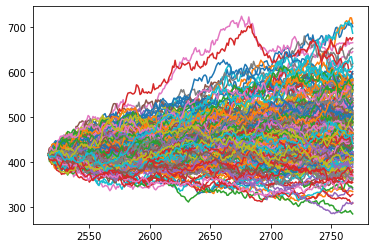

In [6]:
# For Loop for Number of Simulations Desired
for i in range(simulations):
    num_days = [days[-1]]
    close_price = [hist.iloc[-1, 0]]
    
    # For Loop for Number of Days to Predict
    for j in range(days_to_sim):
        num_days.append(num_days[-1]+1)
        perc_change = norm.ppf(random(), loc=mean, scale=std_dev)
        close_price.append(close_price[-1]*(1+perc_change))

    if close_price[-1] > price_orig[-1]:
        above_close.append(1)
    else:
        above_close.append(0)

    close_end.append(close_price[-1])
    plt.plot(num_days, close_price)

Obtaining Results

The final step is displaying and interpreting the results from the simulations. We can calculate the average closing price and percent change after the 200 simulations. We can also determine the probability of SPY increasing after a year by dividing the total of times the predicted closing price is above the 5/4/2022 closing price by the number of simulations (or the length of the list).

In [7]:
# Average Closing Price and Probability of Increasing After 1 Year
average_closing_price = sum(close_end)/simulations
average_perc_change = (average_closing_price-
                       price_orig[-1])/price_orig[-1]
probability_of_increase = sum(above_close)/simulations
print('\nPredicted closing price after ' + str(simulations) + 
      ' simulations: $' + str(round(average_closing_price, 2)))
print('Predicted percent increase after 1 year: ' + 
      str(round(average_perc_change*100, 2)) + '%')
print('Probability of stock price increasing after 1 year: ' + 
      str(round(probability_of_increase*100, 2)) + '%')

# Displaying the Monte Carlo Simulation Lines
plt.show()


Predicted closing price after 200 simulations: $479.36
Predicted percent increase after 1 year: 15.13%
Probability of stock price increasing after 1 year: 75.5%


Notice the predicted average price after a year is $483.89 (16.21% increase from 5/4/2022). There is also a 77.0% likelihood of SPY increasing after a year. As you increase the number of simulations, you will notice that the average price, average percent change, and the probability of the stock increasing converge on certain values. You can also run the code with one simulation to show a randomized result each time (shown below)

https://miro.medium.com/max/700/1*DVBVb-AxYuCxGVq4rlra8g.png

Again, this is not financial advice, so don’t go dumping all your savings into the stock market based on these results. This is simply an example of how to use Monte Carlo simulations and historical data to determine the most likely outcome in a randomized event, such as the stock market. Feel free to build on the model and implement your own twist!